# Table of Contents
* [1. Introduction](#chapter1)
    * [1.1 Notebook Preparation](#section_1_1)

* [2. Data Preparation](#chapter2)
    * [Section 2.1](#section_2_1)
* [Chapter 3](#chapter3)
    * [3.1 One Season Performance](#section_3_1)
    * [3.2 Multiple Seasons Performance](#section_3_2)
        * [3.2.1 Most Important Variables](#sub_section_3_1_1)


## 1.1 Notebook Preparation <a class="anchor" id="section_1_1"></a>

In [133]:
import random

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import os
import pickle

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet ###REMOVE
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [127]:
# Defining the seasons and models used
seasons = ['2023-24','2022-23',
           '2021-22','2020-21','2019-20','2018-19','2017-18','2016-17','2015-16','2014-15','2013-14',
          '2012-13','2011-12','2010-11','2009-10','2008-09','2007-08','2006-07'
          ]
seasons.reverse()
           
models = ['SVM', 'XGBoost','Random Forest','AdaBoost','Gradient Boosting',]#'LGBM']

path = current_path = os.getcwd()
# Path to local folder
path_data = '/Users/von/Desktop/Work/Projects/NBA_MIP_Predictor/NBA-MIP-Model'

sep = r'/'

In [96]:
def get_previous_season(current_season):
    years = current_season.split('-')
    
    first_year = str(int(years[0]) - 1)
    second_year = '{:02d}'.format(int(years[1]) - 1)
    return first_year + '-' + second_year

## 2. Data Preparation <a id="chapter_2"></a>

In [97]:
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 80)

def get_data(seasons):
    
    # Opening the data
    per_game = pd.DataFrame()
    totals = pd.DataFrame()
    difference = pd.DataFrame()
    advanced_stats = pd.DataFrame()
    standings = pd.DataFrame()
    difference_pergame = pd.DataFrame()
    difference_advanced = pd.DataFrame()

    for season in seasons:
        if season == '2004-05':
            break

        updated_path = '/Updated Per Game Seasons'
        updated = "-Updated"
        pergame = pd.read_csv(path_data+sep+'Data'+updated_path+sep+season+'-PerGame'+updated+'.csv',
                               sep=',', decimal='.')

        total = pd.read_csv(path_data+sep+'Data'+sep+season+' Total.csv',
                            sep=',', decimal='.')
        
        advanced = pd.read_csv(path_data+sep+'Data'+updated_path+sep+season+'-Advanced'+updated+'.csv',
                               sep=',', decimal='.')
        
        pergame_previous = pd.read_csv(path_data+sep+'Data'+updated_path+sep+get_previous_season(season)+'-PerGame'+updated+'.csv',
                               sep=',', decimal='.')
                               
        advanced_previous = pd.read_csv(path_data+sep+'Data'+updated_path+sep+get_previous_season(season)+'-Advanced'+updated+'.csv',
                               sep=',', decimal='.')
        
        standing = pd.read_csv(path_data+sep+'Data'+updated_path+sep+season+'-Standings'+updated+'.csv',
                               sep=',', decimal='.')
        
        
        # Getting dataframe for difference of stat averages from previous year
        cols_to_diff_pergame = ['G','GS','MP','FG','FGA','3P','3PA','2P','2PA','FT','FTA','TRB','AST','BLK','TOV','PTS','DRB']
        cols_to_diff_advanced = ['PER','3PAr','ORB%','AST%','STL%','BLK%','USG%','OWS','DWS','WS','WS/48','OBPM','DBPM','BPM','VORP']


        ### Was better not dropping these
        '''
        drop_list = ['3PAr', 'BLK%', 'STL%', 'ORB%', 'OBPM', 'DBPM']
        for stat in drop_list:
            cols_to_diff_advanced.remove(stat)
        '''

        # First, make sure all Players' names are the same in every data file used
        # Using str.replace() to remove all text from *\ or \ onwards
        pergame['Player'] = pergame['Player'].str.replace(r'[\*\\].*', '', regex=True)
        pergame_previous['Player'] = pergame_previous['Player'].str.replace(r'[\*\\].*', '', regex=True)
        advanced['Player'] = advanced['Player'].str.replace(r'[\*\\].*', '', regex=True)
        advanced_previous['Player'] = advanced_previous['Player'].str.replace(r'[\*\\].*', '', regex=True)

        # Remove duplicate players, keeping only the first occurrence
        pergame= pergame.drop_duplicates(subset='Player', keep='first')
        pergame_previous= pergame_previous.drop_duplicates(subset='Player', keep='first')
        advanced= advanced.drop_duplicates(subset='Player', keep='first')
        advanced_previous= advanced_previous.drop_duplicates(subset='Player', keep='first')

        # Merge current and past season to get stats differences
        difference_pergame_season = pd.merge(pergame, pergame_previous, on='Player', suffixes=('_Current', '_Previous'), how='inner')
        difference_advanced_season = pd.merge(advanced, advanced_previous, on='Player', suffixes=('_Current', '_Previous'), how='inner')
        
        #difference_pergame_season = difference_pergame_season.drop_duplicates(subset='Player', keep='first')

        diff_pergame_list = [
            'Player', 'G_diff','GS_diff', 'MP_diff', 'FG_diff', 'FGA_diff', 
            '3P_diff', '3PA_diff', '2P_diff', '2PA_diff', 'FT_diff', 'FTA_diff', 
            'DRB_diff', 'TRB_diff', 'AST_diff', 
            'BLK_diff', 'TOV_diff', 'PTS_diff', 
            'PTS_diff_BS'

        ]
        short_diff_pergame_list = [
            'Player','TRB_diff', 'AST_diff', 'PTS_diff',
        ]
        diff_advanced_list = [
            'Player', 'PER_diff','AST%_diff','USG%_diff','OWS_diff',
            'STL%_diff','BLK%_diff','3PAr_diff','ORB%_diff','OBPM_diff','DBPM_diff',
            'DWS_diff','WS_diff','WS/48_diff','BPM_diff','VORP_diff', 
        ]
        #short_advanced_list

        diff_pergame_percent_list = [
            'Player', 'G_PCT_diff','GS_PCT_diff', 'MP_PCT_diff', 'FG_PCT_diff', 'FGA_PCT_diff', 
            '3P_PCT_diff', '3PA_PCT_diff', '2P_PCT_diff', '2PA_PCT_diff', 'FT_PCT_diff', 'FTA_PCT_diff', 
            'DRB_PCT_diff', 'TRB_PCT_diff', 'AST_PCT_diff', 
            'BLK_PCT_diff', 'TOV_PCT_diff', 'PTS_PCT_diff', 'TRB_diff', 'AST_diff', 'PTS_diff',
        ]
        diff_advanced_percent_list = [
            'Player', 'PER_PCT_diff','AST%_PCT_diff','USG%_PCT_diff','OWS_PCT_diff',
            'STL%_PCT_diff','BLK%_PCT_diff','DBPM_PCT_diff','OBPM_PCT_diff','3PAr_PCT_diff','ORB%_PCT_diff',
            'DWS_PCT_diff','WS_PCT_diff','WS/48_PCT_diff','BPM_PCT_diff','VORP_PCT_diff', 
        ]
        
            


        joined_pergames = diff_pergame_list + diff_pergame_percent_list
        joined_diffs_pergame_list = set(joined_pergames)
        joined_advanced = diff_advanced_list + diff_advanced_percent_list
        joined_diffs_advanced_list = set(joined_advanced)
        # Perform subtraction for specific columns
        get_standard_diffs = True
        get_pct_diffs = False
        #
        #
        #print(difference_pergame_season.columns)
        if get_standard_diffs and not get_pct_diffs:
            for col in cols_to_diff_pergame:
                difference_pergame_season[col + '_diff'] = difference_pergame_season[col + '_Current'] - difference_pergame_season[col + '_Previous']

            # Try to get both ways 
            try:
                difference_pergame_season['PTS_diff_BS'] = difference_pergame_season['PTS_Current'] - difference_pergame_season['BS_PTS_Current']
            except:
                difference_pergame_season['PTS_diff_BS'] = difference_pergame_season['PTS_Current'] - difference_pergame_season['BS_PTS']
            difference_pergame_season = difference_pergame_season[diff_pergame_list]
           # print(difference_pergame_season.columns)
            
            
            for col in cols_to_diff_advanced:
                difference_advanced_season[col + '_diff'] = difference_advanced_season[col + '_Current'] - difference_advanced_season[col + '_Previous']
            difference_advanced_season = difference_advanced_season[diff_advanced_list]



        # Perform % difference for specific columns
        #
        #
        elif get_pct_diffs and not get_standard_diffs:
            for col in cols_to_diff_pergame:
                difference_pergame_season[col + '_PCT_diff'] = (difference_pergame_season[col + '_Current'] - difference_pergame_season[col + '_Previous']) / difference_pergame_season[col + '_Previous']
                
                #Account for possible inf/-inf values
                difference_pergame_season[col + '_PCT_diff'].replace([np.inf, -np.inf], 10.0, inplace=True) 
            
            if not get_standard_diffs:
                ### At minimum need to add PTS, TRB, and AST normal difference
                difference_pergame_season['PTS_diff'] = difference_pergame_season['PTS_Current'] - difference_pergame_season['PTS_Previous']
                difference_pergame_season['AST_diff'] = difference_pergame_season['AST_Current'] - difference_pergame_season['AST_Previous']
                difference_pergame_season['TRB_diff'] = difference_pergame_season['TRB_Current'] - difference_pergame_season['TRB_Previous']
            
            if not get_standard_diffs:
                difference_pergame_season = difference_pergame_season[diff_pergame_percent_list]
            else:
                difference_pergame_season = difference_pergame_season[joined_diffs_pergame_list]
            
            for col in cols_to_diff_advanced:
                difference_advanced_season[col + '_PCT_diff'] = (difference_advanced_season[col + '_Current'] - difference_advanced_season[col + '_Previous']) / difference_advanced_season[col + '_Previous']
                #Account for possible inf/-inf values
                difference_advanced_season[col + '_PCT_diff'].replace([np.inf, -np.inf], 10.0, inplace=True) 

            if not get_standard_diffs:
                difference_advanced_season = difference_advanced_season[diff_advanced_percent_list]
            else:
                difference_advanced_season = difference_advanced_season[joined_diffs_advanced_list]
                
        else:
            for col in cols_to_diff_pergame:
                difference_pergame_season[col + '_diff'] = difference_pergame_season[col + '_Current'] - difference_pergame_season[col + '_Previous']
            for col in cols_to_diff_advanced:
                difference_advanced_season[col + '_diff'] = difference_advanced_season[col + '_Current'] - difference_advanced_season[col + '_Previous']

            for col in cols_to_diff_pergame:
                difference_pergame_season[col + '_PCT_diff'] = (difference_pergame_season[col + '_Current'] - difference_pergame_season[col + '_Previous']) / difference_pergame_season[col + '_Previous']
                
                #Account for possible inf/-inf values
                difference_pergame_season[col + '_PCT_diff'].replace([np.inf, -np.inf], 10.0, inplace=True) 

            difference_pergame_season = difference_pergame_season[joined_diffs_pergame_list]
            
            for col in cols_to_diff_advanced:
                difference_advanced_season[col + '_PCT_diff'] = (difference_advanced_season[col + '_Current'] - difference_advanced_season[col + '_Previous']) / difference_advanced_season[col + '_Previous']
                
                #Account for possible inf/-inf values
                difference_advanced_season[col + '_PCT_diff'].replace([np.inf, -np.inf], 10.0, inplace=True) 

            difference_advanced_season = difference_advanced_season[joined_diffs_advanced_list]

        
        #difference_advanced_season['Player-additional'] = difference_advanced_season['Player-additional_Current']

        
        pergame['Season'] = season
        total['Season'] = season
        advanced['Season'] = season
        standing['Season'] = season
        difference_advanced_season['Season'] = season
        difference_pergame_season['Season'] = season


        
        per_game = pd.concat([per_game,pergame], ignore_index=True)
        totals = pd.concat([totals,total], ignore_index=True)
        advanced_stats = pd.concat([advanced_stats,advanced], ignore_index=True)
        standings = pd.concat([standings,standing], ignore_index=True)
        difference_pergame = pd.concat([difference_pergame, difference_pergame_season], ignore_index=True)
        difference_advanced = pd.concat([difference_advanced, difference_advanced_season], ignore_index=True)
        #difference = difference.merge(difference_advanced, on=['Player','Season','Tm'], how='left', validate='1:1')
    

    #Check occurances of a player
    #player_counts = difference_pergame['Player'].value_counts()
    #count = player_counts.get("DeMar DeRozan", 0)


    # Need to merge advanced stats and pergame stats differences into one dataframe
    difference = pd.merge(difference_pergame, difference_advanced, on=['Player', 'Season'], how='outer', suffixes=('_pergame', '_advanced'))

    return per_game, totals, advanced_stats, standings, difference


In [98]:
def treat_data(per_game, totals, advanced, difference, standings, seasons):
    
    # Removing duplicate/empty columns
    per_game = per_game.drop(['Rk','Pos'], axis=1)
    totals = totals.drop(['Rk','Pos','Age','G','GS'], axis=1)
    advanced = advanced.drop(['Rk','Pos','Age','G','MP','Unnamed: 24','Unnamed: 19', 'Player-additional'], axis=1)

    # Test 2
    # Remove more variables
    per_game = per_game.drop(['GS', 'PF', 'STL', 'eFG%', 'FTA', 'G_prev_total', 'Best Season', 'Previous Season',], axis=1)
    #Need to drop these also
    per_game = per_game.drop(['PS_PTS','PS_TRB','PS_AST','PS_STL','PS_BLK','PS_MP','PS_G','PS_FGA','PS_FG','PS_TOV','PS_3P','PS_3PA',
                            'PS_2P','PS_3P%','PS_2PA','PS_2P%','PS_FT%','BS_PTS','BS_TRB','BS_AST','BS_STL','BS_BLK',
                              'BS_MP','BS_G','BS_FGA','BS_FG','BS_TOV','BS_3P','BS_3PA','BS_2P','BS_3P%','BS_2PA','BS_2P%','BS_FT%'], axis=1)
    totals = totals.drop(['PF'], axis=1)
    
    advanced = advanced.drop(['TRB%', 'DBPM', 'OBPM', 'FTr', 'STL%', 'DRB%', 'BLK%', 'TS%', 'DWS', 'TOV%', 'ORB%', '3PAr', 'Best Season', 
                              'Previous Season'], axis=1)
    #Need to drop these also
    advanced = advanced.drop(['PS_PER','PS_TRB%','PS_AST%','PS_BPM','PS_VORP','PS_USG%','PS_WS','PS_WS/48','BS_PER',
                              'BS_TRB%','BS_AST%','BS_BPM','BS_VORP','BS_USG%','BS_WS','BS_WS/48'], axis=1)

    cols = ['Player','Season','Pos','Age','Tm','G','GS', 'G_prev', 'G_prev_total', 'Seasons Played']

    previous_winners = []
    
    # Identifying the variables
    for col in per_game.columns:
        if col not in cols:
            new_col = col+'_PERGAME'
            per_game = per_game.rename(columns={col:new_col})
    for col in totals.columns:
        if col not in cols:
            new_col = col+'_TOTAL'
            totals = totals.rename(columns={col:new_col})
    for col in advanced.columns:
        if col not in cols:
            new_col = col+'_ADVANCED'
            advanced = advanced.rename(columns={col:new_col})
    
    # Merging the bases
    data = per_game.merge(advanced, on=['Player','Season','Tm'], how='left', validate='1:1')
    
    # Not using Totals anymore
    #data = data.merge(totals, on=['Player','Season','Tm'], how='left', validate='1:1')
    
    #Not using differences for now
    data = data.merge(difference, on=['Player','Season',], how='left', validate='1:1')
    print(data.columns)
    
    dict_teams = {'Utah Jazz':'UTA','Phoenix Suns':'PHO',
                 'Philadelphia 76ers':'PHI','Brooklyn Nets':'BRK',
                 'Denver Nuggets':'DEN','Los Angeles Clippers':'LAC',
                 'Milwaukee Bucks':'MIL','Dallas Mavericks':'DAL',
                 'Los Angeles Lakers':'LAL','Portland Trail Blazers':'POR',
                 'Atlanta Hawks':'ATL','New York Knicks':'NYK',
                 'Miami Heat':'MIA','Golden State Warriors':'GSW',
                 'Memphis Grizzlies':'MEM','Boston Celtics':'BOS',
                 'Washington Wizards':'WAS','Indiana Pacers':'IND',
                 'Charlotte Hornets':'CHO','Charlotte Bobcats':'CHA',
                 'San Antonio Spurs':'SAS','Chicago Bulls':'CHI',
                 'New Orleans Pelicans':'NOP','Sacramento Kings':'SAC',
                 'Toronto Raptors':'TOR','Minnesota Timberwolves':'MIN',
                 'Cleveland Cavaliers':'CLE','Oklahoma City Thunder':'OKC',
                 'Orlando Magic':'ORL','Detroit Pistons':'DET',
                 'Houston Rockets':'HOU','New Jersey Nets':'NJN',
                 'New Orleans Hornets':'NOH','Seattle SuperSonics':'SEA'}
    
    teams = pd.DataFrame.from_dict(dict_teams, orient='index').reset_index()
    teams = teams.rename(columns={'index':'Team',0:'Tm'})
    standings = standings.merge(teams, on='Team', how='left', validate='m:1')
    wins = (standings['Record'].str.split('-',expand=True)[0]).astype(int)
    games = ((standings['Record'].str.split('-',expand=True)[0]).astype(int)+(standings['Record'].str.split('-',expand=True)[1]).astype(int))
    standings['PCT'] = wins/games
    
    data = data.merge(standings, on=['Tm','Season'], how='left', validate='m:1')
    
    data['Player'] = data['Player'].str.replace('*','')
    
    ###mvps = pd.read_csv(path_data+sep+'Dados'+sep+'MVPs.csv',sep=',', decimal='.') ###Change to MIPS

    mips = pd.read_csv(path_data+sep+'Data'+sep+'MIPs.csv',sep=',', decimal='.')


    ###data = data.merge(mvps, on=['Player','Season'], how='left', validate='m:1').fillna(0)  
    data = data.merge(mips, on=['Player','Season'], how='left', validate='m:1').fillna(0) 
    data = data.drop(['Won already'], axis=1)

    data['Player'] = data['Player'].str.split('\\', expand=True)[0]
    #print(data)
    
    # Removing duplicate lines from traded players, removing players from seasons that have already won the award
    dataf = pd.DataFrame()
    
    for season in seasons:
        data_season = data[data['Season']==season]
        data_season = data_season.drop_duplicates(subset=['Player'], keep='first')

        # Remove players who already won
        data_season = data_season[~data_season['Player'].isin(previous_winners)]

        result = mips[(mips['MIP Rank'] == '1') & (mips['Season'] == season)]
        #print(result)
        #print(mips[(mips['MIP Rank'] == '1') & (mips['Season'] == season)])
        
        # Add winning player to winners list
        winner_name = result['Player'].tolist()[0]
        if winner_name not in previous_winners:
            previous_winners.append(winner_name)
            #print(winner_name)
        
        
        #print(season)
        dataf = pd.concat([dataf,data_season], ignore_index=True)

    print(dataf.columns)

    # Filtering the data (MIP)
    dataf = dataf[((dataf['G']>50)&(dataf['Age'] <= 30)&(dataf['PTS_PERGAME']>=9.7)&(dataf['G_prev']>45)
                   &(dataf['FGA_PERGAME']>=7.8)&(dataf['MP_PERGAME']>=22.9)&(dataf['PER_ADVANCED']>=14.2)
                   &(dataf['TRB_PERGAME']>=2.6)&(dataf['AST_PERGAME']>=0.7)&(dataf['FG%_PERGAME']>0.41)
                   &(dataf['PTS_diff']>=1.3)&(dataf['TRB_diff']>=-1.0)&(dataf['PER_ADVANCED']<=27.7) 
                   &(dataf['AST_diff']>=-1.5)&(dataf['PTS_PERGAME']<=27.4)) | ((dataf['MIP Share']>=0.1)&(dataf['G_prev']>35))].reset_index(drop=True)

    # Base for the MIP criteria
    # Darrell Armstrong was MIP in 98-99 with 50 games, oldest age 30
    # Isaac Austin was MIP in 96-97 with 9.7 PPG, 7.8 FGA, 22.9 MPG, 14.2 PER
    # Aaron Brooks was MIP in 2009-10 with 2.6 RPG
    # Gheorghe Muresan was MIP in 95-96 with 0.7 APG
    # Paul George was MIP in 2012-13 with 41.9% FG
    
    # Since 2001-02
    # PPG difference from previous season >= 4.5
    # PPG diff of top 3 candidates >= 1.3
    # RPG diff top 3 >=  -1.0
    # APG diff top3 >= -1.5
    # Season before >= 41 games played
        
    dataf = dataf.drop(['Tm','Team',
                        'Record'
    ], 
                        axis=1)
    dataf.to_csv("FinalDataFrame.csv", index=False)
    
    return dataf

In [99]:
pd.options.display.max_seq_items = 203

per_game, totals, advanced, standings, difference = get_data(seasons)



#print("Breaks")
#per_game

In [100]:
data = treat_data(per_game, totals, advanced, difference, standings, seasons)

Index(['Player', 'Age', 'Tm', 'G', 'MP_PERGAME', 'FG_PERGAME', 'FGA_PERGAME',
       'FG%_PERGAME', '3P_PERGAME', '3PA_PERGAME', '3P%_PERGAME', '2P_PERGAME',
       '2PA_PERGAME', '2P%_PERGAME', 'FT_PERGAME', 'FT%_PERGAME',
       'ORB_PERGAME', 'DRB_PERGAME', 'TRB_PERGAME', 'AST_PERGAME',
       'BLK_PERGAME', 'TOV_PERGAME', 'PTS_PERGAME', 'G_prev', 'Seasons Played',
       'Season', 'PER_ADVANCED', 'AST%_ADVANCED', 'USG%_ADVANCED',
       'OWS_ADVANCED', 'WS_ADVANCED', 'WS/48_ADVANCED', 'BPM_ADVANCED',
       'VORP_ADVANCED', 'G_diff', 'GS_diff', 'MP_diff', 'FG_diff', 'FGA_diff',
       '3P_diff', '3PA_diff', '2P_diff', '2PA_diff', 'FT_diff', 'FTA_diff',
       'DRB_diff', 'TRB_diff', 'AST_diff', 'BLK_diff', 'TOV_diff', 'PTS_diff',
       'PTS_diff_BS', 'PER_diff', 'AST%_diff', 'USG%_diff', 'OWS_diff',
       'STL%_diff', 'BLK%_diff', '3PAr_diff', 'ORB%_diff', 'OBPM_diff',
       'DBPM_diff', 'DWS_diff', 'WS_diff', 'WS/48_diff', 'BPM_diff',
       'VORP_diff'],
      dtype='object')


In [101]:
pd.options.display.max_rows = 532
#data
data[data["MIP Rank"].isin(["1", "2", "2T"])][["MIP Rank","Player","Season", "Seed", "PTS_diff", "PTS_diff_BS", 'USG%_ADVANCED','USG%_diff']]

,MIP Rank,Player,Season,Seed,PTS_diff,PTS_diff_BS,USG%_ADVANCED,USG%_diff
13,1,Monta Ellis,2006-07,12.0,9.7,9.7,22.4,2.2
23,2,Kevin Martin,2006-07,23.0,9.4,9.4,23.2,5.8
41,2,Rudy Gay,2007-08,27.0,9.3,9.3,25.0,3.7
60,1,Hedo Türkoğlu,2007-08,9.0,6.2,4.6,24.8,3.1
76,1,Danny Granger,2008-09,18.0,6.2,6.2,29.6,6.4
78,2,Devin Harris,2008-09,21.0,6.5,6.5,28.4,5.8
100,1,Aaron Brooks,2009-10,16.0,8.4,8.4,25.7,2.8
102,2T,Kevin Durant,2009-10,10.0,4.8,4.8,32.0,3.7
104,2T,Marc Gasol,2009-10,18.0,2.7,2.7,16.9,-1.4
106,2T,George Hill,2009-10,12.0,6.7,6.7,19.0,-0.5


In [102]:
pd.options.display.max_rows = 4000
pd.options.display.max_seq_items = 4000
data.columns

Index(['Player', 'Age', 'G', 'MP_PERGAME', 'FG_PERGAME', 'FGA_PERGAME',
       'FG%_PERGAME', '3P_PERGAME', '3PA_PERGAME', '3P%_PERGAME', '2P_PERGAME',
       '2PA_PERGAME', '2P%_PERGAME', 'FT_PERGAME', 'FT%_PERGAME',
       'ORB_PERGAME', 'DRB_PERGAME', 'TRB_PERGAME', 'AST_PERGAME',
       'BLK_PERGAME', 'TOV_PERGAME', 'PTS_PERGAME', 'G_prev', 'Seasons Played',
       'Season', 'PER_ADVANCED', 'AST%_ADVANCED', 'USG%_ADVANCED',
       'OWS_ADVANCED', 'WS_ADVANCED', 'WS/48_ADVANCED', 'BPM_ADVANCED',
       'VORP_ADVANCED', 'G_diff', 'GS_diff', 'MP_diff', 'FG_diff', 'FGA_diff',
       '3P_diff', '3PA_diff', '2P_diff', '2PA_diff', 'FT_diff', 'FTA_diff',
       'DRB_diff', 'TRB_diff', 'AST_diff', 'BLK_diff', 'TOV_diff', 'PTS_diff',
       'PTS_diff_BS', 'PER_diff', 'AST%_diff', 'USG%_diff', 'OWS_diff',
       'STL%_diff', 'BLK%_diff', '3PAr_diff', 'ORB%_diff', 'OBPM_diff',
       'DBPM_diff', 'DWS_diff', 'WS_diff', 'WS/48_diff', 'BPM_diff',
       'VORP_diff', 'Seed', 'Previous Seed', 'See

In [103]:
data['Season'].value_counts() # Number of players in the data per season\

2013-14    42
2016-17    35
2006-07    34
2010-11    33
2017-18    32
2008-09    31
2018-19    31
2007-08    31
2012-13    29
2020-21    28
2019-20    28
2015-16    28
2021-22    26
2014-15    25
2009-10    25
2022-23    25
2023-24    24
2011-12    22
Name: Season, dtype: int64

In [104]:
# Function for metrics
def func_metrics(y_test, y_pred, metrics, model, season):
    rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)),3) # RMSE
    r2 = round(r2_score(y_test, y_pred),3) # R²
    
    dict_met = {'Model': [model],
                'Season': [season],
                'RMSE': [rmse],
                'R²': [r2]}
    
    metric = pd.DataFrame(data=dict_met)
    metrics = pd.concat([metrics,metric])
    
    return metrics

## 3. Training Models <a id="chapter_3"></a>

In [105]:
def func_models(data, seasons, models, n_seasons_to_test):
    final_results = pd.DataFrame()
    metrics = pd.DataFrame()
    best_params = []
    i = 1

    for season in seasons:

        # Separating training and testing bases
        season_test = season

        data_train = data[data['Season']!=season_test]
        data_test = data[data['Season']==season_test]


        regular_diffs = ['PTS_diff', 'AST_diff', 'TRB_diff']
        final_drops = []

        # Test 2
        X_train = data_train.drop(['MIP Share','MIP Rank','Player','Season',] + final_drops, axis=1)#'G_prev','FGA_PERGAME', 'PER_ADVANCED', 'FG%_PERGAME'], axis=1)
        y_train = data_train['MIP Share']

        X_test = data_test.drop(['MIP Share','MIP Rank','Player','Season',]+ final_drops, axis=1) #'G_prev','FGA_PERGAME', 'PER_ADVANCED', 'FG%_PERGAME'], axis=1)
        y_test = data_test['MIP Share']

        initial_results = data_test[['Player','Season','MIP Share','MIP Rank']]
        results = initial_results.copy()
        print(len(X_train.columns))

        scaler = StandardScaler()

        scaled_X_train = scaler.fit_transform(X_train)
        scaled_X_test = scaler.transform(X_test)

        for model in models:
            # Creating instance for each model
            if model=='SVM':
                param_grid = {'C': [0.001,0.01,0.1,0.5,1,2,5,10],
                             'kernel': ['linear','rbf','poly'],
                             'gamma': ['scale','auto'],
                             'degree': [2,3,4],
                             'epsilon': [0.1,0.5,1]}
                svr_model = SVR()
                grid = GridSearchCV(svr_model, param_grid)
                grid.fit(scaled_X_train, y_train)
                final_model = SVR(**grid.best_params_)
                best_params.append(grid.best_params_)

            elif model=='Elastic Net':
                param_grid = {'alpha':[0.01,0.1,1,5,10,50,100],
                              'l1_ratio':[0.01,0.1,0.5,0.7,0.95,0.99,1]}
                elastic_net_model = ElasticNet()
                grid = GridSearchCV(elastic_net_model, param_grid)
                grid.fit(scaled_X_train, y_train)
                grid.best_params_
                final_model = ElasticNet(**grid.best_params_)
                best_params.append(grid.best_params_)
            elif model=='XGBoost':
                param_grid = {'n_estimators': [100, 200],
                              'learning_rate': [0.01, 0.1],
                              'max_depth': [3, 5, 7],
                              'subsample': [0.7, 1.0]}
                xg_boost = XGBRegressor()
                grid = GridSearchCV(xg_boost, param_grid)
                grid.fit(scaled_X_train, y_train)
                grid.best_params_
                final_model = XGBRegressor(**grid.best_params_)
                best_params.append(grid.best_params_)
                
            elif model=='Random Forest':
                param_grid = {'n_estimators': [15,25,50,64,100,150,200],
                             'max_features': [2,3,4,5],
                             'bootstrap': [True,False],
                             'oob_score': [True]}
                rfc = RandomForestRegressor()
                grid = GridSearchCV(rfc, param_grid)
                grid.fit(scaled_X_train, y_train)
                final_model = RandomForestRegressor(**grid.best_params_)
                best_params.append(grid.best_params_)
                
            elif model=='AdaBoost':
                param_grid = {'n_estimators': [5,10,20,30,40,50,100],
                             'learning_rate': [0.01,0.05,0.1,0.2,0.5]}
                ada_model = AdaBoostRegressor()
                grid = GridSearchCV(ada_model, param_grid)
                grid.fit(scaled_X_train, y_train)
                final_model = AdaBoostRegressor(**grid.best_params_)
                best_params.append(grid.best_params_)
                
            elif model=='Gradient Boosting':
                param_grid = {'n_estimators': [10,20,30,40,50],
                             'learning_rate': [0.01,0.05,0.1,0.2,0.5],
                             'max_depth': [3,4,5]}
                gb_model = GradientBoostingRegressor()
                grid = GridSearchCV(gb_model, param_grid)
                grid.fit(scaled_X_train, y_train)
                final_model = GradientBoostingRegressor(**grid.best_params_)
                best_params.append(grid.best_params_)
                
            elif model=='LGBM':
                param_grid = {'learning_rate':[0.01,0.1,0.2,0.3],
                              'num_leaves':[5,10,20,30],
                              'min_data_in_leaf':[10,25,50],
                              'min_child_samples': [10, 25, 50],
                              'max_depth':[2,3,4],
                              'feature_fraction':[0.6,0.7,0.8,0.9],
                              'min_gain_to_split':[0,0.01,0.1,0.2],
                              'verbose':[-1]}
                lgbm_model = LGBMRegressor()
                grid = GridSearchCV(lgbm_model, param_grid)
                grid.fit(scaled_X_train, y_train)
                final_model = LGBMRegressor(**grid.best_params_)
                best_params.append(grid.best_params_)
                
            final_model.fit(scaled_X_train, y_train)
            
            print("FM:")
            print(final_model)
            print("SEP: ")
            print(sep)
            print("MODEL: ")
            print(model)
            pickle.dump(final_model,open(path_data+sep+'Models'+sep+model+'.dat','wb'))#,'wb')
            
            y_pred = final_model.predict(scaled_X_test)
            metrics = func_metrics(y_test, y_pred, metrics, model, season)

            temp_df = initial_results.copy()
            temp_df['Predicted MIP Share '+model] = pd.Series(y_pred).values

            results_sorted = temp_df.sort_values(by='Predicted MIP Share '+model,
                                                ascending=False).reset_index(drop=True)
            results_sorted['MIP Rank '+model] = results_sorted.index+1

            results = results.merge(results_sorted, on=['Player','Season','MIP Share','MIP Rank'])

        final_results = pd.concat([final_results,results], ignore_index=True)

        if i == n_seasons_to_test:
            break

        i = i + 1
    
    np.savetxt(path_data+sep+r'Models\params.csv', best_params, delimiter =', ', fmt ='% s')
    
    return final_results, metrics, best_params

In [106]:
def average_metrics(metrics):
    # Averages of each of the models
    final_metrics = pd.DataFrame()
    for model in metrics['Model'].unique():
        metric = metrics[metrics['Model']==model]
        rmse = round(metric['RMSE'].mean(),3)
        r2 = round(metric['R²'].mean(),3)

        dict_met = {'Model': [model],
                    'RMSE': [rmse],
                    'R²': [r2]}

        data_frame = pd.DataFrame(data=dict_met)
        final_metrics = pd.concat([final_metrics,data_frame], ignore_index=True)
    return final_metrics

## 3.1 One Season Performance <a id='section_3_1'></a>

In [107]:
pd.options.display.max_rows = 50

final_results_one_season, metrics, best_params = func_models(data, seasons, models, 1)
final_metrics = average_metrics(metrics)
final_metrics

68
FM:
SVR(C=0.001, degree=2, kernel='linear')
SEP: 
/
MODEL: 
SVM
FM:
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
SEP: 
/
MODEL: 
XGBoost
FM:
RandomForestRegressor(max_features=3, n_estimators=200, oob_score=True)
SEP: 
/
MODEL: 
Random Forest
FM:
AdaBoostRegressor(learning_rate=0.5, n_estimators=20

,Model,RMSE,R²
0,SVM,0.112,0.244
1,XGBoost,0.100,0.400
2,Random Forest,0.100,0.395
3,AdaBoost,0.103,0.368
4,Gradient Boosting,0.116,0.187


In [139]:
def create_rank(final_results_season, n_rank):
    rank_final = pd.DataFrame()

    scores = {
        'MIP Rank SVM': 0,
        'MIP Rank XGBoost': 0,
        'MIP Rank Random Forest': 0,
        'MIP Rank AdaBoost': 0,
        'MIP Rank Gradient Boosting': 0,
        'MIP Rank LGBM': 0
    }

    for season in final_results_season['Season'].unique():
        temp = final_results_season[final_results_season['Season']==season]
        rank = pd.DataFrame()
        rank_real = temp.sort_values(by='MIP Share', ascending=False)[:n_rank].reset_index(drop=True)
        rank['MIP Rank Real'] = rank_real['Player']
        rank['MIP Share Real'] = rank_real['MIP Share']
        for model in models:
            try:
                temp2 = temp.sort_values(by='Predicted MIP Share '+model, ascending=False)[:n_rank].reset_index(drop=True)
                rank['MIP Rank '+model] = temp2['Player']
                rank['MIP Share '+model] = round(temp2['Predicted MIP Share '+model],3)
            except:
                continue

        rank['Season'] = season    
        rank_final = pd.concat([rank_final, rank], ignore_index=True)

    for i, row in rank_final.iterrows():
        for model in models:
            if row['MIP Rank Real'] == row['MIP Rank '+model]:
                scores['MIP Rank '+model] += 1
    
    return rank_final, scores

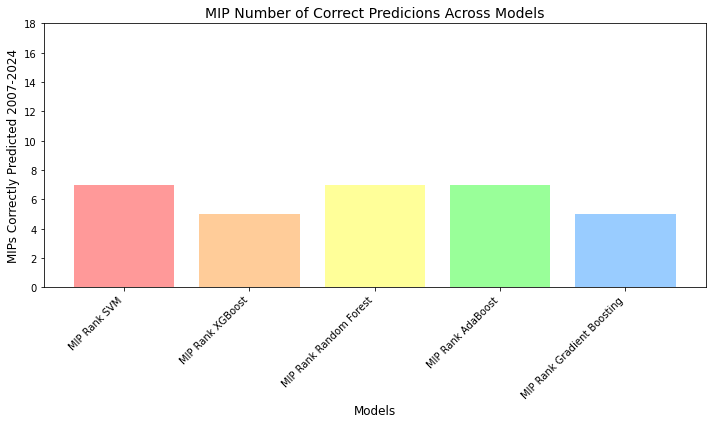

In [140]:
rank_final, scores = create_rank(final_results_one_season, 1)

#Don't include LGBM if it wasn't used
if scores['MIP Rank LGBM'] == 0:
    scores.pop('MIP Rank LGBM')

# Creating the bar graph
model_names = list(scores.keys())
values = list(scores.values())

colors = ['#FF9999', '#FFCC99', '#FFFF99', '#99FF99', '#99CCFF', '#CC99FF']
plt.figure(figsize=(10, 6))
plt.bar(model_names, values, color=colors)

# Setting the labels and title
plt.xlabel('Models', fontsize=12)
plt.ylabel('Top 3 candidates correctly predicted 2007', fontsize=12)
plt.title('MIP Top 3 candidate Correct Predicions Across Models', fontsize=14)

# Adjust y-axis to max value 18
plt.ylim(0, 18)

# Display the plot
plt.xticks(rotation=45, ha='right')  # Rotate x labels for better visibility
plt.tight_layout()
plt.show()

In [141]:
rank_final

,MIP Rank Real,MIP Share Real,MIP Rank SVM,MIP Share SVM,MIP Rank XGBoost,MIP Share XGBoost,MIP Rank Random Forest,MIP Share Random Forest,MIP Rank AdaBoost,MIP Share AdaBoost,MIP Rank Gradient Boosting,MIP Share Gradient Boosting,Season
0,Monta Ellis,0.546,Deron Williams,0.198,Kevin Martin,0.378,Kevin Martin,0.292,Kevin Martin,0.400,Kevin Martin,0.407,2006-07
1,Hedo Türkoğlu,0.608,Hedo Türkoğlu,0.162,Ronnie Brewer,0.211,Ronnie Brewer,0.181,Richard Jefferson,0.101,Ronnie Brewer,0.212,2007-08
2,Danny Granger,0.602,Brandon Roy,0.141,Danny Granger,0.198,Danny Granger,0.173,Danny Granger,0.146,Kevin Durant,0.143,2008-09
3,Aaron Brooks,0.655,Kevin Durant,0.214,Channing Frye,0.218,Kevin Durant,0.307,Channing Frye,0.224,Andrew Bogut,0.206,2009-10
4,Kevin Love,0.690,Derrick Rose,0.192,Derrick Rose,0.323,Derrick Rose,0.384,Derrick Rose,0.484,Derrick Rose,0.370,2010-11
5,Ryan Anderson,0.430,Nikola Peković,0.145,Nikola Peković,0.222,Nikola Peković,0.191,Nikola Peković,0.126,Nikola Peković,0.149,2011-12
6,Paul George,0.518,James Harden,0.269,James Harden,0.479,James Harden,0.402,James Harden,0.546,James Harden,0.514,2012-13
7,Goran Dragić,0.648,Anthony Davis,0.189,DeMarcus Cousins,0.338,Anthony Davis,0.274,Anthony Davis,0.626,Anthony Davis,0.283,2013-14
8,Jimmy Butler,0.829,Rudy Gobert,0.217,Jimmy Butler,0.428,Jimmy Butler,0.288,Jimmy Butler,0.454,Jimmy Butler,0.422,2014-15
9,CJ McCollum,0.860,CJ McCollum,0.281,CJ McCollum,0.273,CJ McCollum,0.266,CJ McCollum,0.493,CJ McCollum,0.216,2015-16


## 3.2 Multiple Seasons Performance <a id='section_3_2'></a>

In [111]:
def old_seasons(data, seasons, models, n_seasons_to_test):
    final_results = pd.DataFrame()
    metrics = pd.DataFrame()
    best_params = []
    i = 1

    for season in seasons:
            
        # Separating training and testing bases
        season_test = season

        data_train = data[data['Season']!=season_test]
        data_test = data[data['Season']==season_test]

        regular_diffs = ['PTS_diff', 'AST_diff', 'TRB_diff']
        final_drops = []

        X_train = data_train.drop(['MIP Share','MIP Rank','Player','Season',]+final_drops, axis=1)#'G_prev','FGA_PERGAME', 'PER_ADVANCED', 'FG%_PERGAME'], axis=1)
        y_train = data_train['MIP Share']

        X_test = data_test.drop(['MIP Share','MIP Rank','Player','Season']+final_drops, axis=1)#,'FGA_PERGAME', 'PER_ADVANCED', 'FG%_PERGAME','G_prev'], axis=1)
        y_test = data_test['MIP Share']

        initial_results = data_test[['Player','Season','MIP Share','MIP Rank']]
        results = initial_results.copy()

        scaler = StandardScaler()

        scaled_X_train = scaler.fit_transform(X_train)
        scaled_X_test = scaler.transform(X_test)

        for model in models:
            
            if model=='Elastic Net':
                continue
            
            # Opening the models already created          
            current_model = pickle.load(open(path_data+sep+'Models'+sep+model+'.dat', 'rb'))
                
            current_model.fit(scaled_X_train, y_train)
            y_pred = current_model.predict(scaled_X_test)
            metrics = func_metrics(y_test, y_pred, metrics, model, season)

            apoio = initial_results.copy()
            apoio['Predicted MIP Share '+model] = pd.Series(y_pred).values

            results_sorted = apoio.sort_values(by='Predicted MIP Share '+model,
                                                ascending=False).reset_index(drop=True)
            results_sorted['MIP Rank '+model] = results_sorted.index+1

            results = results.merge(results_sorted, on=['Player','Season','MIP Share','MIP Rank'])

        final_results = pd.concat([final_results,results], ignore_index=True)

        if i == n_seasons_to_test:
            break

        i = i + 1
        
    return final_results, metrics

In [112]:
pd.options.display.max_rows = 100
pd.options.display.max_seq_items = 100
final_results, metrics = old_seasons(data, seasons, models, 18)
final_metricas = average_metrics(metrics)
final_metricas

,Model,RMSE,R²
0,SVM,0.130,0.247
1,XGBoost,0.121,0.303
2,Random Forest,0.121,0.320
3,AdaBoost,0.125,0.235
4,Gradient Boosting,0.124,0.287


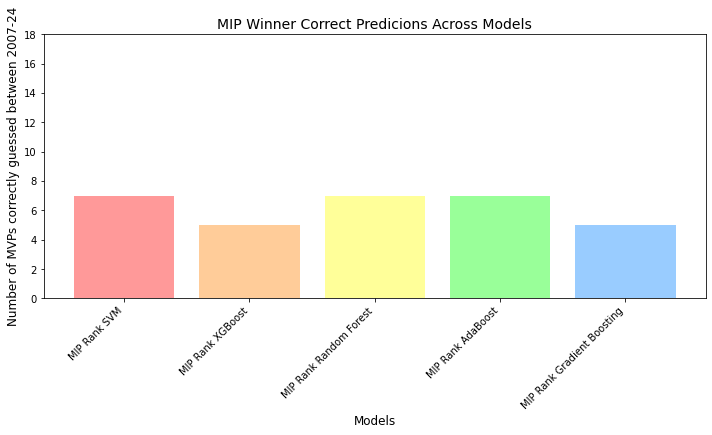

In [143]:
pd.options.display.max_rows = 400

rank_final, scores = create_rank(final_results, 1)

#Don't include LGBM if it wasn't used
if scores['MIP Rank LGBM'] == 0:
    scores.pop('MIP Rank LGBM')

# Creating the bar graph
model_names = list(scores.keys())
values = list(scores.values())

colors = ['#FF9999', '#FFCC99', '#FFFF99', '#99FF99', '#99CCFF', '#CC99FF']
plt.figure(figsize=(10, 6))
plt.bar(model_names, values, color=colors)

# Setting the labels and title
plt.xlabel('Models', fontsize=12)
plt.ylabel('Number of MVPs correctly guessed between 2007-24', fontsize=12)
plt.title('MIP Winner Correct Predicions Across Models', fontsize=14)

# Adjust y-axis to max value 18
plt.ylim(0, 18)

# Display the plot
plt.xticks(rotation=45, ha='right')  # Rotate x labels for better visibility
plt.tight_layout()
plt.show()


In [122]:
rank_final

,MIP Rank Real,MIP Share Real,MIP Rank SVM,MIP Share SVM,MIP Rank XGBoost,MIP Share XGBoost,MIP Rank Random Forest,MIP Share Random Forest,MIP Rank AdaBoost,MIP Share AdaBoost,MIP Rank Gradient Boosting,MIP Share Gradient Boosting,Season
0,Monta Ellis,0.546,Deron Williams,0.198,Kevin Martin,0.378,Kevin Martin,0.292,Kevin Martin,0.400,Kevin Martin,0.407,2006-07
1,Hedo Türkoğlu,0.608,Hedo Türkoğlu,0.162,Ronnie Brewer,0.211,Ronnie Brewer,0.181,Richard Jefferson,0.101,Ronnie Brewer,0.212,2007-08
2,Danny Granger,0.602,Brandon Roy,0.141,Danny Granger,0.198,Danny Granger,0.173,Danny Granger,0.146,Kevin Durant,0.143,2008-09
3,Aaron Brooks,0.655,Kevin Durant,0.214,Channing Frye,0.218,Kevin Durant,0.307,Channing Frye,0.224,Andrew Bogut,0.206,2009-10
4,Kevin Love,0.690,Derrick Rose,0.192,Derrick Rose,0.323,Derrick Rose,0.384,Derrick Rose,0.484,Derrick Rose,0.370,2010-11
5,Ryan Anderson,0.430,Nikola Peković,0.145,Nikola Peković,0.222,Nikola Peković,0.191,Nikola Peković,0.126,Nikola Peković,0.149,2011-12
6,Paul George,0.518,James Harden,0.269,James Harden,0.479,James Harden,0.402,James Harden,0.546,James Harden,0.514,2012-13
7,Goran Dragić,0.648,Anthony Davis,0.189,DeMarcus Cousins,0.338,Anthony Davis,0.274,Anthony Davis,0.626,Anthony Davis,0.283,2013-14
8,Jimmy Butler,0.829,Rudy Gobert,0.217,Jimmy Butler,0.428,Jimmy Butler,0.288,Jimmy Butler,0.454,Jimmy Butler,0.422,2014-15
9,CJ McCollum,0.860,CJ McCollum,0.281,CJ McCollum,0.273,CJ McCollum,0.266,CJ McCollum,0.493,CJ McCollum,0.216,2015-16


In [114]:
data_test = data[data['Season']=='2023-24']
data_train = data[data['Season']!='2023-24']

regular_diffs = ['PTS_diff', 'AST_diff', 'TRB_diff']
final_drops = []

X_test = data_test.drop(['MIP Share','MIP Rank','Player','Season',] + final_drops, axis=1) #'G_prev' 'FGA_PERGAME', 'PER_ADVANCED', 'FG%_PERGAME'], axis=1)
X_train = data_train.drop(['MIP Share','MIP Rank','Player','Season' ,] + final_drops, axis=1) #'G_prev'  'FGA_PERGAME', 'PER_ADVANCED', 'FG%_PERGAME'], axis=1)

scaler = StandardScaler()
scaler.fit(X_train)
feature_names = X_test.columns
print(feature_names)

scaled_X_test = scaler.transform(X_test)
scaled_X_test_df = pd.DataFrame(scaled_X_test, columns=feature_names)
#scaled_X_test_df

Index(['Age', 'G', 'MP_PERGAME', 'FG_PERGAME', 'FGA_PERGAME', 'FG%_PERGAME',
       '3P_PERGAME', '3PA_PERGAME', '3P%_PERGAME', '2P_PERGAME', '2PA_PERGAME',
       '2P%_PERGAME', 'FT_PERGAME', 'FT%_PERGAME', 'ORB_PERGAME',
       'DRB_PERGAME', 'TRB_PERGAME', 'AST_PERGAME', 'BLK_PERGAME',
       'TOV_PERGAME', 'PTS_PERGAME', 'G_prev', 'Seasons Played',
       'PER_ADVANCED', 'AST%_ADVANCED', 'USG%_ADVANCED', 'OWS_ADVANCED',
       'WS_ADVANCED', 'WS/48_ADVANCED', 'BPM_ADVANCED', 'VORP_ADVANCED',
       'G_diff', 'GS_diff', 'MP_diff', 'FG_diff', 'FGA_diff', '3P_diff',
       '3PA_diff', '2P_diff', '2PA_diff', 'FT_diff', 'FTA_diff', 'DRB_diff',
       'TRB_diff', 'AST_diff', 'BLK_diff', 'TOV_diff', 'PTS_diff',
       'PTS_diff_BS', 'PER_diff', 'AST%_diff', 'USG%_diff', 'OWS_diff',
       'STL%_diff', 'BLK%_diff', '3PAr_diff', 'ORB%_diff', 'OBPM_diff',
       'DBPM_diff', 'DWS_diff', 'WS_diff', 'WS/48_diff', 'BPM_diff',
       'VORP_diff', 'Seed', 'Previous Seed', 'Seed Difference', 'PCT'

In [115]:
svm_model = pickle.load(open(path_data+sep+'Models'+sep+'Gradient Boosting.dat','rb'))


In [116]:
# Define a prediction function
def predict_fn(X):
    return svm_model.predict(X)

# Use SHAP's KernelExplainer
explainer = shap.KernelExplainer(predict_fn, shap.sample(scaled_X_test_df, 100))
shap_values = explainer.shap_values(scaled_X_test_df)


  0%|          | 0/24 [00:00<?, ?it/s]

## 3.2.1 Important Variables <a id='sub_section_3_2_1'></a>

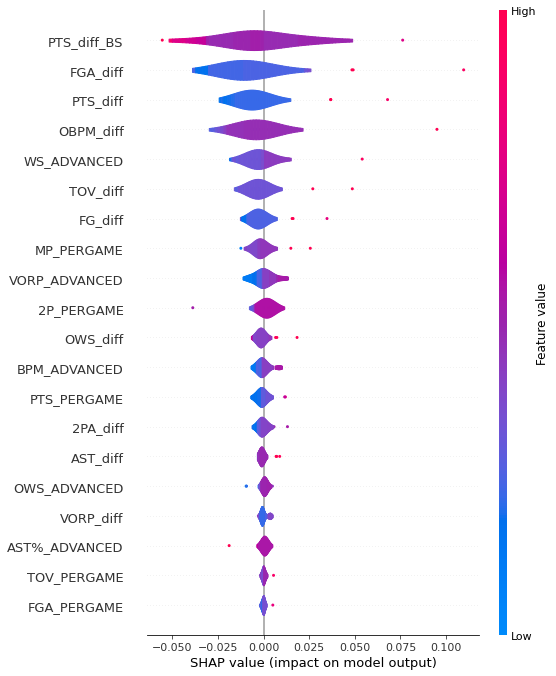

In [118]:
shap.summary_plot(shap_values, scaled_X_test_df,plot_type='violin') #X_test, plot_type='violin') # Top 20 variables

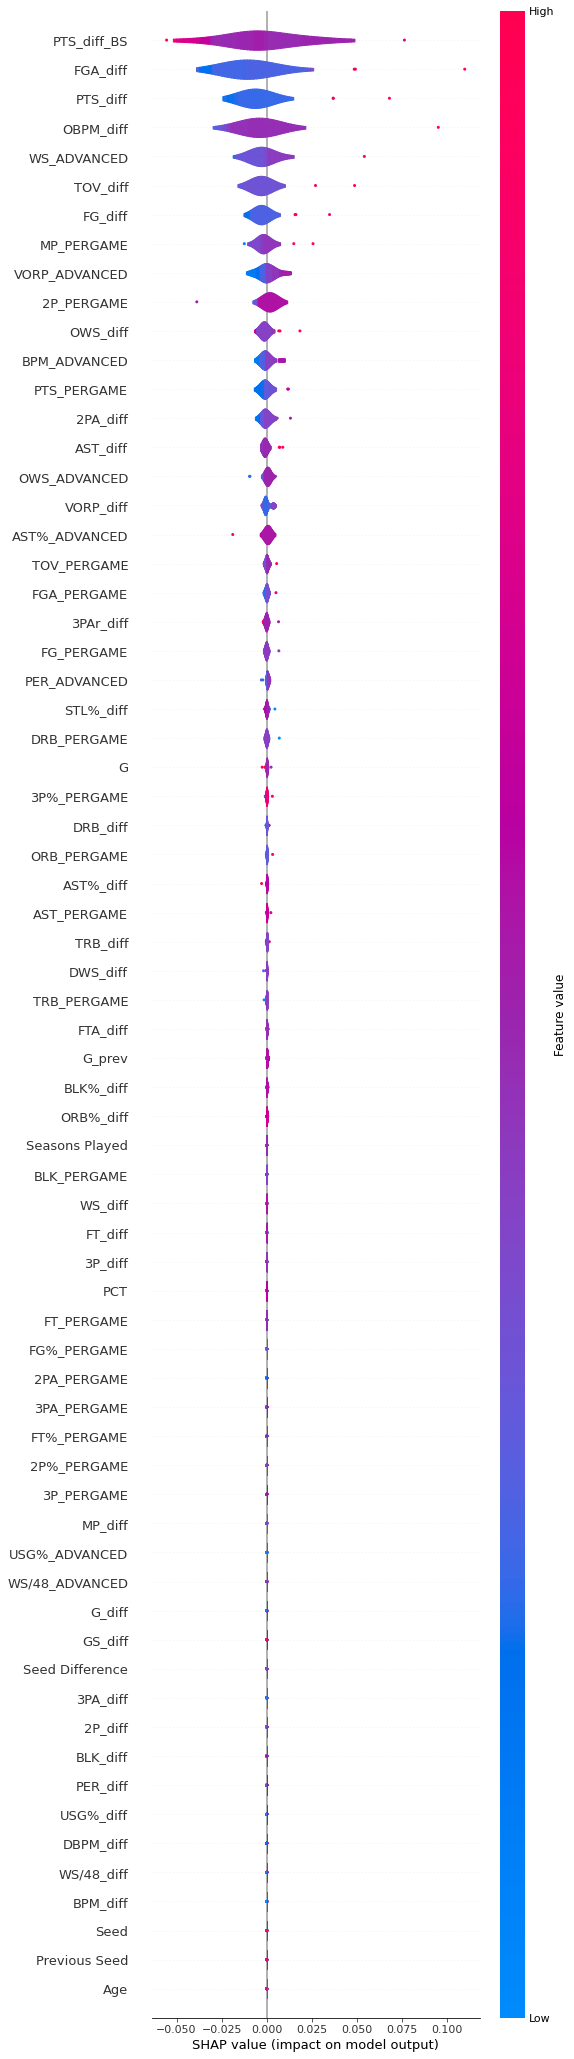

In [119]:
shap.summary_plot(shap_values, X_test, plot_type='violin', max_display=len(X_test.columns)) # All features